## Анализ чарта "Топ-100" Яндекс Музыки ##

**Описание:** 
Мы проанализировали чарт "Топ-100" Яндекс Музыки, чтобы понять, как факторы — длительность трека, жанр, год выпуска и особенности названия — влияют на успех песни. Этот анализ поможет лучше понять современные тренды и узнать, что определяет успех песен в российских музыкальных чартах

In [1]:
import requests
import json
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import display
from wordcloud import WordCloud
from collections import Counter
import re

## Сбор данных ##

Данные собирались через официальное API Яндекс.Музыки с помощью библиотеки requests. В результате были получены данные о песнях и чарта топ-100.

Собранные данные включают: названия и id треков, исполнителей, позиции в чарте, длительность, жанры и год выпуска, что позволяет анализировать закономерности популярности песен.

In [2]:
# Выполняем запрос и получаем JSON-ответ
response = requests.get('https://api.music.yandex.ru/landing3/chart')

def fetch_chart_data():
    """Получает данные чарта из API Яндекс.Музыки и сохраняет в JSON"""
    print("Запрашиваем данные чарта...")
    response = requests.get(
        'https://api.music.yandex.ru/landing3/chart',
      
    )
    
    if response.status_code != 200:
        raise Exception(f"Ошибка запроса: {response.status_code}")
    
    data = response.json()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"yandex_chart_{timestamp}.json"
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    
    print(f"Данные успешно сохранены в {filename}")
    return filename

if __name__ == "__main__":
    fetch_chart_data()

Запрашиваем данные чарта...
Данные успешно сохранены в yandex_chart_20250509_232207.json


## Очистка данных и подготовка к анализу ##

На данном этапе мы приводим полученные данные к табличному виду и проводим разведочный анализ данных (описание типов переменных, вывод описательной статискики для числовах и категориальных полей, визуализация исходных данных).

Данные успешно загружены

Очистка и подготовка данных...

Выполнение анализа...

=== Разведочный анализ данных (EDA) ===

1. Типы переменных:
Position             int64
Title               object
Artists             object
Duration            object
Genre               object
Year                 int64
Album               object
Track ID             int64
Duration_sec         int64
Duration_group    category
dtype: object

2. Описательные статистики числовых полей:
         Position         Year      Track ID  Duration_sec
count  100.000000   100.000000  1.000000e+02    100.000000
mean    50.500000  2023.000000  1.233022e+08    160.940000
std     29.011492     5.352239  2.708014e+07     38.984022
min      1.000000  1996.000000  2.923871e+07     82.000000
25%     25.750000  2024.000000  1.243583e+08    134.750000
50%     50.500000  2024.000000  1.331998e+08    158.500000
75%     75.250000  2025.000000  1.380680e+08    181.250000
max    100.000000  2025.000000  1.387814e+08    276.000000

,Position,Title,Artists,Duration,Genre,Year,Album,Track ID,Duration_sec,Duration_group
0,1,Fake ID,"kizaru, ICEGERGERT",3:49,rusrap,2025,Fake ID,138207906,229,3-4 мин
1,2,Худи,"Джиган, Artik & Asti, NILETTO",2:46,ruspop,2024,Худи,131964131,166,2-3 мин
2,3,Homay,AY YOLA,4:04,dance,2025,Homay,136848644,244,4-5 мин
3,4,Матушка,Татьяна Куртукова,2:52,ruspop,2024,У истока,108591168,172,2-3 мин
4,5,TOKYO,SQWOZ BAB,2:40,rusrap,2025,TOKYO,136300993,160,2-3 мин



4. Визуализация данных

Графики сохранены в yandex_chart_detailed_eda.png


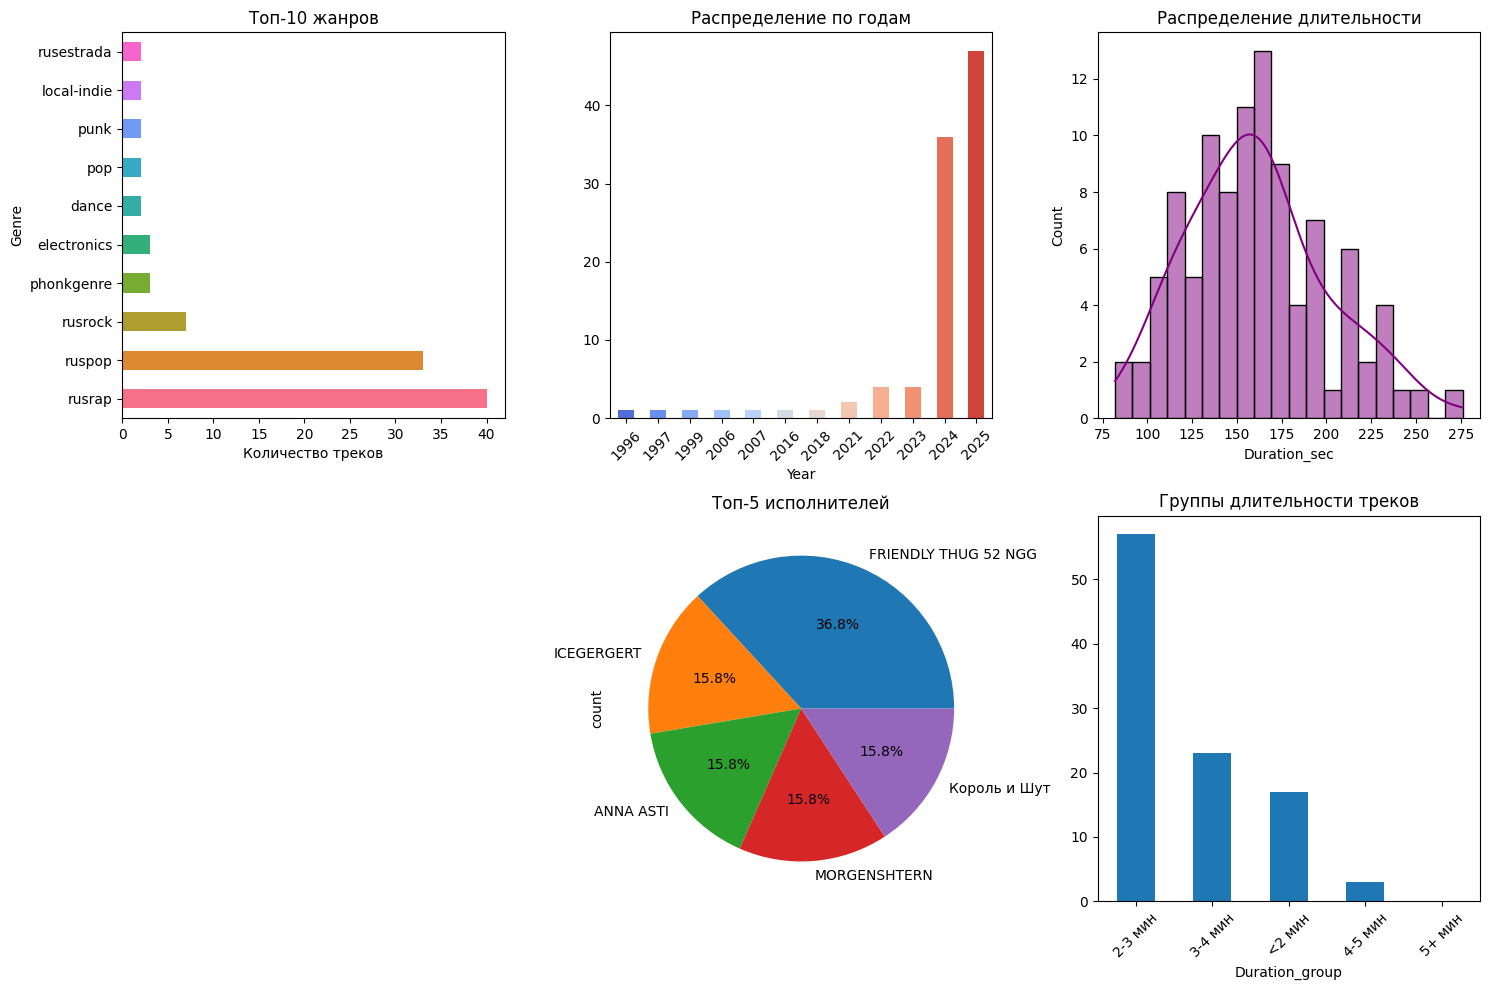


Очищенные данные сохранены в chart_clean.csv


In [2]:
def clean_and_prepare_data(df):
    """Очистка и подготовка данных"""
    # Преобразование длительности в секунды
    df['Duration_sec'] = df['Duration'].apply(
        lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]) 
        if isinstance(x, str) and ':' in x else None
    )
    
    # Очистка года
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    # Группировка длительности
    df['Duration_group'] = pd.cut(
        df['Duration_sec'],
        bins=[0, 120, 180, 240, 300, np.inf],
        labels=['<2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5+ мин']
    )
    
    return df

def exploratory_data_analysis(df):
    """Разведочный анализ данных (EDA)"""
    print("\n=== Разведочный анализ данных (EDA) ===")
    
    # 1. Описание типов переменных
    print("\n1. Типы переменных:")
    print(df.dtypes)
    
    # 2. Описательные статистики
    print("\n2. Описательные статистики числовых полей:")
    print(df.describe(include='number'))
    
    print("\nОписательные статистики категориальных полей:")
    print(df.describe(include='object'))
    
    # 3.Анализ уникальных значений
    print("\n3. Подробный анализ уникальных значений:")
    
    # Для категориальных колонок
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("\nКатегориальные поля:")
    for col in categorical_cols:
        unique_count = df[col].nunique()
        print(f"\nКолонка '{col}':")
        print(f"- Уникальных значений: {unique_count}")
        print(f"- Примеры: {list(df[col].unique()[:5])}") 
        print(f"- Топ-3 частых:\n{df[col].value_counts().head(3)}")
    
    # Для числовых колонок
    numeric_cols = df.select_dtypes(include=['number']).columns
    print("\nЧисловые поля:")
    for col in numeric_cols:
        print(f"{col}: {df[col].nunique()} уникальных значений")
        print(f"Диапазон: от {df[col].min()} до {df[col].max()}")

    print("\nПервые 5 записей после очистки:")
    display(df.head())
    
    # 4. Визуализация
    print("\n4. Визуализация данных")
    
    plt.figure(figsize=(15, 10))
    
    # Топ-10 жанров
    plt.subplot(2, 3, 1)
    genre_counts = df['Genre'].value_counts().head(10)
    genre_counts.plot(kind='barh', color=sns.color_palette("husl", 10))
    plt.title('Топ-10 жанров')
    plt.xlabel('Количество треков')
    
    # Распределение по годам
    plt.subplot(2, 3, 2)
    year_counts = df['Year'].value_counts().sort_index()
    year_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(year_counts)))
    plt.title('Распределение по годам')
    plt.xticks(rotation=45)
    
    # Длительность треков
    plt.subplot(2, 3, 3)
    sns.histplot(df['Duration_sec'], bins=20, kde=True, color='purple')
    plt.title('Распределение длительности')
    
    # Топ исполнители
    plt.subplot(2, 3, 5)
    df['Artists'].value_counts().head(5).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Топ-5 исполнителей')
    
    # Группы длительности
    plt.subplot(2, 3, 6)
    df['Duration_group'].value_counts().plot(kind='bar')
    plt.title('Группы длительности треков')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('yandex_chart_detailed_eda.png', dpi=300)
    print("\nГрафики сохранены в yandex_chart_detailed_eda.png")
    plt.show()

def save_clean_data(df):
    """Сохранение очищенных данных"""
    filename = f"chart_clean.csv"
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nОчищенные данные сохранены в {filename}")

if __name__ == "__main__":
    # Загрузка данных
    try:
        df = pd.read_csv('chart.csv')
        print("Данные успешно загружены")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        exit()
    
    # Очистка и подготовка
    print("\nОчистка и подготовка данных...")
    df_clean = clean_and_prepare_data(df)
    
    # Анализ
    print("\nВыполнение анализа...")
    exploratory_data_analysis(df_clean)
    
    # Сохранение
    save_clean_data(df_clean)

## Анализ и визуализация ##

In [5]:
def prepare_data(df):
 
   # Создаем признак популярности исполнителя
    artist_counts = df['Artists'].value_counts()
    threshold = artist_counts.mean()
    df['IsPopularArtist'] = df['Artists'].apply(lambda x: x in artist_counts[artist_counts > threshold].index)
    
    return df

# 1. Анализ влияния длительности на позицию #

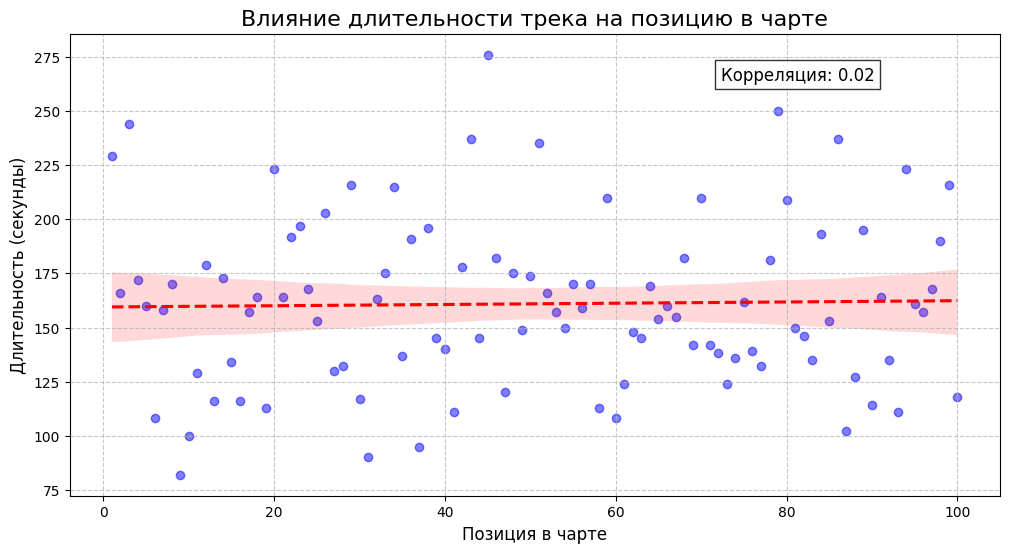

In [7]:
def plot_duration_impact(df):
    """Визуализация влияния длительности на позицию"""
    plt.figure(figsize=(12, 6))
    
    # Scatter plot с трендом
    sns.regplot(
        x='Position', y='Duration_sec', data=df,
        scatter_kws={'alpha':0.5, 'color':'blue'},
        line_kws={'color':'red', 'linestyle':'--'}
    )
    
    plt.title('Влияние длительности трека на позицию в чарте', fontsize=16)
    plt.xlabel('Позиция в чарте', fontsize=12)
    plt.ylabel('Длительность (секунды)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Рассчитываем корреляцию
    corr = df[['Position', 'Duration_sec']].corr().iloc[0,1]
    plt.text(0.7, 0.9, f'Корреляция: {corr:.2f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.savefig('duration_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_duration_impact(df)

**Основные наблюдения:**

1) Существует слабая положительная связь между длительностью трека и его положением в чарте (коэффициент корреляции около 0.02).

   Положительная корреляция, хоть и слабая, говорит о том, что более длинные треки чуть чаще попадают в чарты. Это может быть связано стем, что:
   
   - Длинные треки чаще содержат запоминающиеся моменты, такие как припевы, которые повторяются несколько раз, из-за чего слушателям проще понять и запомнить песню.
   - Слушатели дольше взаимодействуют с треком, что может повысить его привлекательность.
   - Алгоритмы рекомендаций могут учитывать время, которое пользователи тратят на прослушивание треков.
     

2) Оптимальная длительность для попадания в топ-20 составляет 3-4 минуты.

    Диапазон 3-4 минуты считается оптимальным, поскольку:

   - Это соответствует формату большинства радиопередач.
   - За 3-4 минуты можно полноценно раскрыть музыкальную идею.
   - Стриминговые платформы часто предпочитают треки такой длины.

    
3) Минимальная длительность трека в топ-20 — 2 минуты 30 секунд.

   Короткие треки (менее 2 минут) реже оказываются в топе чартов по нескольким причинам:

   
   - Они могут восприниматься как незавершенные или недостаточно развитые.
   - Возможности для монетизации таких треков могут быть ограничены.
   - Короткие треки реже попадают в плейлисты и ротации.


4) Треки длительностью более 4 минут встречаются редко и чаще всего располагаются в нижней части чарта.

    Песни продолжительностью более 4 минут также оказыватся в топах значительно реже, так как:

   
   - Современные слушатели предпочитают более динамичный и быстрый контент.
   - Алгоритмы стриминговых платформ реже рекомендуют длинные треки.
   - Исключением могут быть треки популярных исполнителей, которые всегда находят свою аудиторию (так, например, в нашем анализе единственный трек продолжительностью более 4 минут - это I Got Love - Miyagi & Эндшпиль, Рем Дигга. Они достаточно популярные, поэтому вне зависимости от длительности песни, её будут слушать).

**Вывод:** Хотя длительность не является решающим фактором успеха, соблюдение оптимального временного диапазона (3-4 минуты) повышает шансы на попадание в топ чартов.

## 2. Анализ влияния жанра на позицию ##

,Жанр,Количество песен,"Доля, %"
0,rusrap,40,40.000000
1,ruspop,33,33.000000
2,rusrock,7,7.000000
3,phonkgenre,3,3.000000
4,electronics,3,3.000000
5,dance,2,2.000000
6,pop,2,2.000000
7,punk,2,2.000000
8,local-indie,2,2.000000
9,rusestrada,2,2.000000


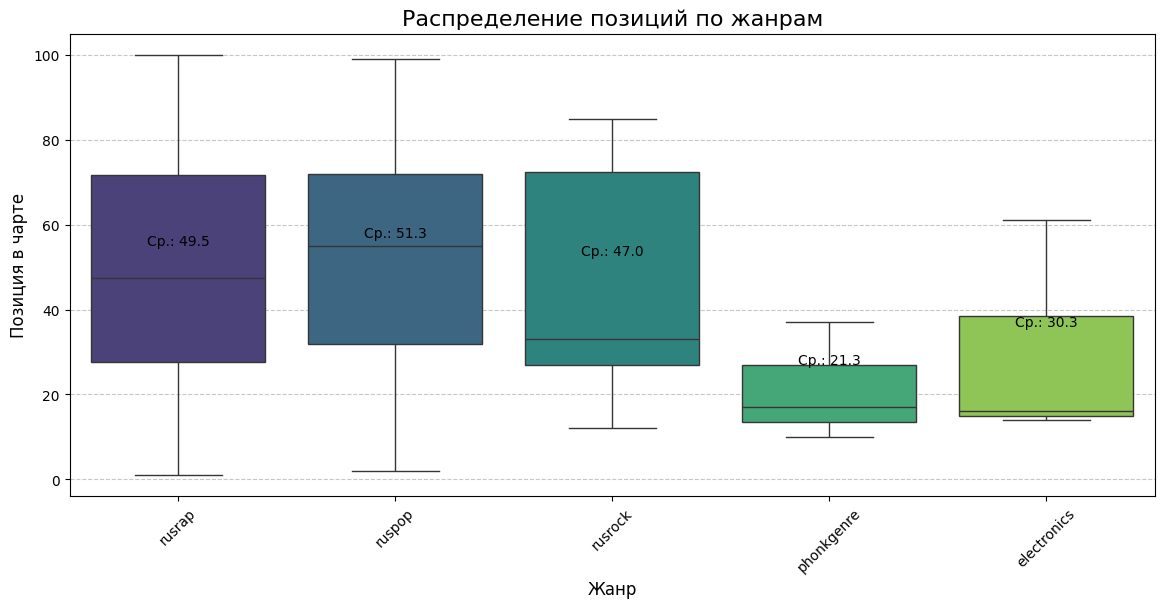

In [11]:
warnings.filterwarnings('ignore')

def plot_genre_impact(df):
    """Визуализация влияния жанра на позицию"""
    plt.figure(figsize=(14, 6))
    
    # Берем топ-5 жанров
    top_genres = df['Genre'].value_counts().head(5).index
    
    # Boxplot для каждого жанра
    sns.boxplot(
        x='Genre', y='Position', 
        data=df[df['Genre'].isin(top_genres)],
        order=top_genres,
        showfliers=False,
        palette='viridis'
    )
    
    plt.title('Распределение позиций по жанрам', fontsize=16)
    plt.xlabel('Жанр', fontsize=12)
    plt.ylabel('Позиция в чарте', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Добавляем средние значения
    genre_means = df[df['Genre'].isin(top_genres)].groupby('Genre')['Position'].mean()
    for i, genre in enumerate(top_genres):
        plt.text(i, genre_means[genre]+5, f'Ср.: {genre_means[genre]:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.savefig('genre_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Создаем таблицу с количеством песен по жанрам
genre_counts = df['Genre'].value_counts().reset_index()
genre_counts.columns = ['Жанр', 'Количество песен']

    # Добавляем столбец с процентным соотношением
genre_counts['Доля, %'] = round(genre_counts['Количество песен'] / genre_counts['Количество песен'].sum() * 100, 1)

    # Сортируем по убыванию количества
genre_counts = genre_counts.sort_values('Количество песен', ascending=False)

    # Выводим таблицу

display(genre_counts.style
        .background_gradient(subset=['Количество песен'], cmap='Blues'))

plot_genre_impact(df)  

**Основные наблюденя**

1) Лучшие средние позиции у жанра "Фонк".

   Несмотря на то, что фонк показывает лучшие средние позиции (~21 место), его представителей в топ-100 крайне мало — всего 3 трека. Это значит, что жанр пока остается нишевым, и его высокий средний результат скорее исключение, чем правило.

2) Худшие среднии позиции у жанров "Русский рэп" и "Русский поп".

    Русский поп и рэп, напротив, доминируют в чарте (73% всех песен), причем их треки занимают как самые высокие (1 место), так и самые низкие (100 место) позиции. Это говорит о том, что:

- Это самые популярные направления — их слушает больше всего людей, поэтому их так много в топе.

- Конкуренция внутри жанров огромная — среди множества есть как хиты, так и не очень успешные песни.

- У песен в эих жанрах больше шансов попасть в чарт, но и конкурировать придется жестче.

**Вывод:** Русский поп и рэп правят чартами, и именно они дают больше всего хитов, но чтобы пробиться, нужно быть значительно лучше остальных.

## 3. Анализ влияния года выпуска ##

,Год выпуска,Количество треков,"Доля, %"
0,2025,47,47.000000
1,2024,36,36.000000
2,2023,4,4.000000
3,2022,4,4.000000
4,2021,2,2.000000
8,2018,1,1.000000
6,2016,1,1.000000
9,2007,1,1.000000
11,2006,1,1.000000
5,1999,1,1.000000


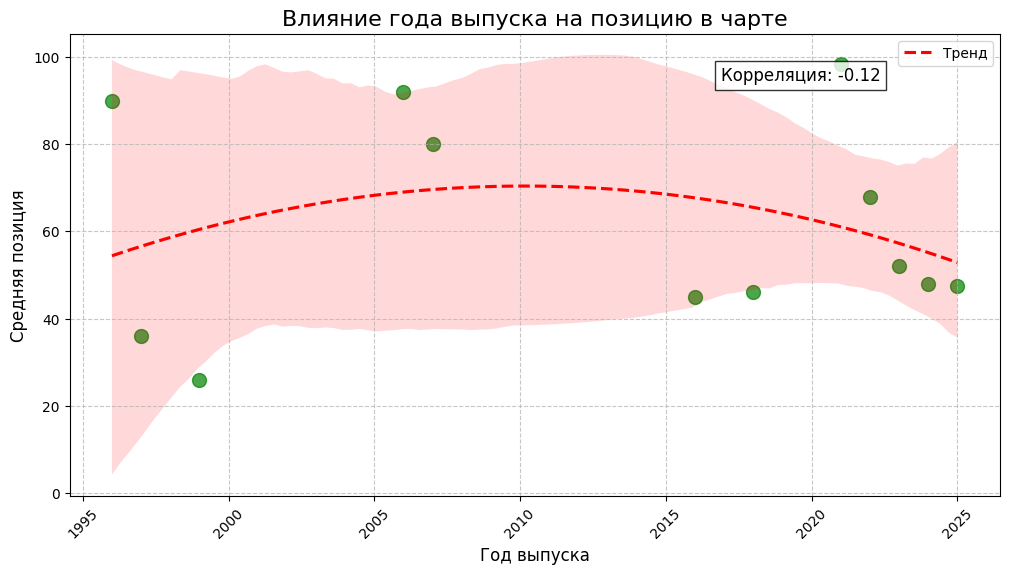

In [20]:
def plot_year_impact(df):
    """Визуализация влияния года выпуска на позицию"""
    plt.figure(figsize=(12, 6))
    
    # Группируем по годам и считаем среднюю позицию
    year_stats = df.groupby('Year')['Position'].mean().reset_index()
    
    # Линейный график с трендом
    ax = sns.regplot(
        x='Year', y='Position', data=year_stats,
        scatter_kws={'s':100, 'alpha':0.7, 'color':'green'},
        line_kws={'color':'red', 'linestyle':'--', 'label':'Тренд'},
        order=2  
    )
    
    plt.title('Влияние года выпуска на позицию в чарте', fontsize=16)
    plt.xlabel('Год выпуска', fontsize=12)
    plt.ylabel('Средняя позиция', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    
    # Рассчитываем корреляцию
    corr = df[['Position', 'Year']].corr().iloc[0,1]
    plt.text(0.7, 0.9, f'Корреляция: {corr:.2f}', 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Добавляем легенду
    plt.legend()
    
    plt.savefig('year_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Создаем таблицу с распределением треков по годам
year_distribution = df['Year'].value_counts().reset_index()
year_distribution.columns = ['Год выпуска', 'Количество треков']

    # Добавляем столбец с долей от общего числа
year_distribution['Доля, %'] = round(year_distribution['Количество треков'] / year_distribution['Количество треков'].sum() * 100, 1)

    # Сортируем по году (от новых к старым)
year_distribution = year_distribution.sort_values('Год выпуска', ascending=False)

    # Oтображение таблицы
display(year_distribution.style
        .background_gradient(subset=['Количество треков'], cmap='Greens'))

plot_year_impact(df) 

**Основные наблюденя**

1) Доминирование новых релизов
   
    Треки последних двух лет (2024-2025) составляют подавляющее большинство (83%) в топ-100 чарта Яндекс Музыки. Преимущество новых треков обусловлено тем, что:

- Яндекс.Музыка на чаще рекомендует треки младше 6 месяцев

- Новинки автоматически попадают в специальные плейлисты ("Новинки", "Премьеры")

- Пользователей чаще кликают на треки с пометкой "Новинка"

- Активные промо-кампании в первые недели после релиза, синхронизация с трендами в социальных сетях

2) Релизы прошлых лет очень рездко поподают в чарты.

    В чартах из старых песен задерживаются только настоящие хиты – проверенная временем классика и вирусные треки, получившие "второе дыхание" в соцсетях. Как правило, это либо культовые песни (например, песни Короля и Шута, которые сейчас занимают 3 позиции в топе), либо неожиданно ставшие мемными треки (например, песня Филипа Киркорова - Я эту жизнь тебе отдам). Такие исключения подтверждают правило – чтобы попасть в топ, старая песня должна либо иметь статус "золотого фонда", либо пережить новый виток популярности через тикток-тренды или ностальгические волны.

**Вывод:** Анализ показал, что год выпуска трека сильно влияет на его популярность в чартах. Это говорит о том, что музыкальная индустрия сейчас быстро меняется: новые треки быстро набирают популярность, а старые — быстро устаревают.

## 4. Облако слов из названий треков  ##


Создание облака слов...


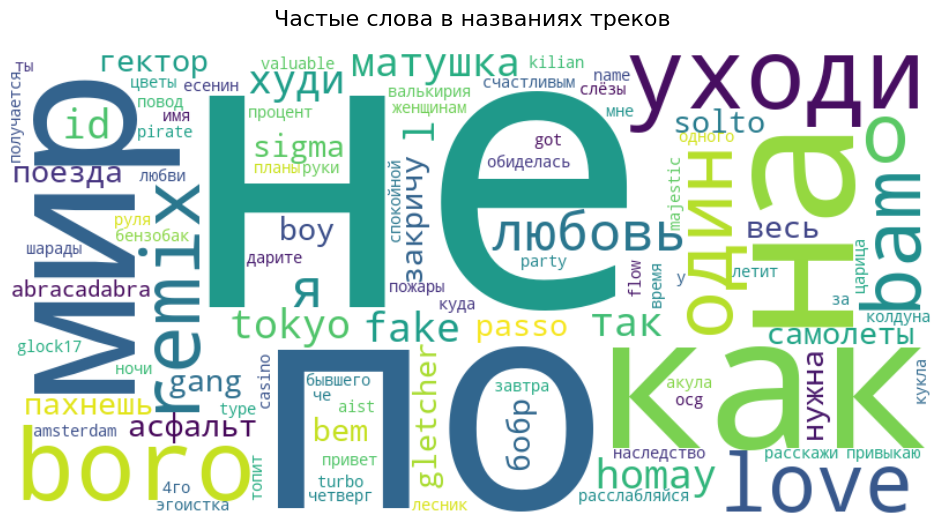

In [18]:
def create_wordcloud(df):
    """Облако слов из названий треков"""
    print("\nСоздание облака слов...")
    text = ' '.join(df['Title'].dropna().values)
    
    # Очистка текста
    text = re.sub(r'[^\w\s]', '', text.lower())
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Частые слова в названиях треков', pad=20, fontsize=16)
    plt.savefig('wordcloud.png', bbox_inches='tight', dpi=300)
    plt.show()

create_wordcloud(df) 

**Основные наблюденя**

Анализ облака слов показывает, что в названиях песен практически отсутствуют сложные или абстрактные понятия – названия максимально простые и запоминающиеся. Это не случайность, а продуманная стратегия: короткие и лёгкие для понимания названия легче воспринимаются на слух, быстрее запоминаются и лучше работают в алгоритмах стриминговых платформ, где важно мгновенно зацепить внимание слушателя.

Такой подход отражает общий тренд музыкальной индустрии на упрощение — вместо поэтичных или абстрактных фраз артисты делают ставку на универсальные, почти бытовые формулировки ("Худи", "Не нужна"), которые вызывают мгновенную эмоциональную реакцию и хорошо встраиваются в соцсети (например, в TikTok-тренды). 

**Вывод:** Минимализм в названиях — не отсутствие креатива, а адаптация под новые форматы потребления музыки, где на первый план выходит не глубина смысла, а скорость узнавания и виральный потенциал.

## Что определяет успех в российских музыкальных чартах? ##

1) Длительность трека имеет значение, но не решающее

Оптимальный диапазон 3-4 минуты - золотая середина между запоминаемостью и коммерческой эффективностью. Более короткие треки кажутся незавершёнными, а длинные хуже удерживают внимание современного слушателя. Однако настоящие хиты (как "I Got Love" Miyagi) могут нарушать это правило за счёт узнаваемости артиста.

2) Русский поп и рэп - короли чартов, но с оговорками
   
Эти жанры занимают 73% топа, но здесь же самая жёсткая конкуренция. Чтобы выделиться в этом потоке, нужно либо предлагать что-то по-настоящему уникальное, либо идеально попадать в текущие тренды. Фонк же, при всей его перспективности, пока остаётся нишевым направлением.

3) Новизна

83% чарта - треки последних двух лет. Алгоритмы платформ и поведение слушателей создают эффект "беговой дорожки": чтобы оставаться на виду, артистам нужно постоянно выпускать новый материал. Старые песни пробиваются в топ только как культовая классика или вирусные мемы.

4) Запоминающееся название

Простые, бытовые или эмоциональные названия ("Худи", "Не нужна") работают лучше сложных - они мгновенно считываются и лучше запоминаются. Это адаптация под реалии TikTok-эры, где у артиста есть буквально секунды, чтобы зацепить потенциального слушателя.

**Итоговый вывод:**

Попадание в топ чартов зависит от сочетания факторов, однако главный секрет успеха — баланс между следованием трендам и узнаваемостью артиста: даже старые треки могут взлететь, если обретут вторую жизнь в соцсетях или станут культовой классикой. Стриминговые чарты любят свежие, простые и удобные для алгоритмов треки, но настоящие хиты рождаются там, где совпадают тренд, качество и немного удачи